 - 分别抓取奔驰/宝马/奥迪车型的投诉数据

In [75]:
import requests
import re
import xlwt
from lxml import etree

In [76]:
# ben_url
bz_url = 'http://www.12365auto.com/zlts/8-114-0-0-0-0_0-0-0-0-0-0-0-' # url前缀，共有29页
bm_url = 'http://www.12365auto.com/zlts/7-86-0-0-0-0_0-0-0-0-0-0-0-' # url前缀，共有19页
ad_url = 'http://www.12365auto.com/zlts/1-3-0-0-0-0_0-0-0-0-0-0-0-'  # url前缀，共有71页
    
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36'
}

In [77]:
# 通过两个函数解析投诉数据
def issue(page):
    url = bm_url + str(page) + '.shtml'  # 将bz_url替换为bm/ad即可得到宝马/奥迪
    response = requests.get(url, headers)
    html = etree.HTML(response.text) # 通过etree.HTML构建xpath解析对象
    return html.xpath('//tr')[1:]

def issue_detail(issue_list):
    issue = []
    for complanint in issue_list:
        no = complanint.xpath('./td[1]/text()')[0]
        brand = complanint.xpath('./td[2]/text()')[0]
        model = complanint.xpath('./td[3]/text()')[0]
        car_type= complanint.xpath('./td[4]/text()')[0]
        problem = complanint.xpath('./td[5]/a/text()')[0]
        # key_word = scrapy.Field()
        data = complanint.xpath('./td[7]/text()')[0]
        issue.append((no,brand,model,car_type,problem,data))
    
    return issue # 返回一页的投诉数据

In [80]:
# 测试
issue_detail(issue(2))[:2]

[('433491',
  '华晨宝马',
  '宝马3系',
  '2019款 320Li 时尚型',
  '华晨宝马3系左前轮异响4S店未查出原因',
  '2019-12-14'),
 ('433474',
  '华晨宝马',
  '宝马3系',
  '2013款 320Li 2.0T 自动 改款风尚设计套装',
  '华晨宝马3系变速箱漏油要求厂家解决',
  '2019-12-13')]

In [81]:
# 数据写入excel

wb = xlwt.Workbook(encoding='utf-8') #创建excel文件，声明编码
ws = wb.add_sheet('issue-bmw')
headData = ['投诉编号','品牌','车型','车款','投诉问题','投诉日期']
for column in range(6):
    ws.write(0, column, headData[column],xlwt.easyxf('font:bold on') ) #文件头部
    
def to_excel(items, index):
    for item in items:
        for i in range(6):
            ws.write(index, i, item[i])# 行，列，数据
        # print("page{} write done!".format(index))
        index += 1

In [82]:
for each in range(1,19):
    index = (each - 1)*30 + 1
    to_excel(issue_detail(issue(each)), index)
    
newtable = 'BBA质量投诉-bmw.xls'
wb.save(newtable)

# 以下为数据分析部分

## 主要内容有：
  - 总体来看：
   - 1. 三个品牌的投诉占比
   - 2. 按照时间顺序，统计月份投诉数量
   
  - 分品牌分析：
   - 1. 该车系的故障次云
   - 2. 故障和车型的关系
   - 3. 故障和时间的关系

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
plt.rcParams['font.sans-serif'] = ['SimHei'] #中文字符显示问题
plt.style.use('ggplot') # 风格
%matplotlib inline

In [23]:
df = pd.read_excel('D:\\数据科学家之路\\BBA\\BBA质量投诉.xls')
df.head()

,投诉编号,品牌,车型,车款,投诉问题,投诉日期
0,449177,一汽-大众奥迪,奥迪A4L,2017款 2.0T 双离合 进取型,节温器漏防冻液严重,2020-02-28
1,448806,一汽-大众奥迪,奥迪A4L,2019款 40 TFSI 时尚型 国V,经销商服务态度差,2020-02-26
2,448786,一汽-大众奥迪,奥迪A4L,2017款 2.0T 双离合 风尚型,发动机水泵故障节温器漏水,2020-02-26
3,448632,一汽-大众奥迪,奥迪A4L,2019款 40 TFSI 进取型 国VI,行驶中提示变速箱故障,2020-02-25
4,448241,一汽-大众奥迪,奥迪A4L,2016款 2.0T CVT 舒适型 典藏版,节温器故障要求召回处理,2020-02-22


 - 数据集查看

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3450 entries, 0 to 3449
Data columns (total 6 columns):
投诉编号    3450 non-null int64
品牌      3450 non-null object
车型      3450 non-null object
车款      3450 non-null object
投诉问题    3450 non-null object
投诉日期    3450 non-null object
dtypes: int64(1), object(5)
memory usage: 161.8+ KB


 - 查看车型投诉数量比重

In [25]:
len(df['车型'])

3450

In [26]:
df_percent = df['车型'].value_counts().reset_index().rename(columns = {'index':'车型', '车型':'投诉数量'})
df_percent

,车型,投诉数量
0,奥迪A4L,2070
1,奔驰C级,840
2,宝马3系,540


In [27]:
df_percent = df['车型'].value_counts().reset_index().rename(columns = 
                                {'index':'车型', '车型':'投诉数量'})
df_percent['百分比'] = df_percent['投诉数量']/len(df['车型'])
df_percent

,车型,投诉数量,百分比
0,奥迪A4L,2070,0.600000
1,奔驰C级,840,0.243478
2,宝马3系,540,0.156522


Text(0.5, 1.0, ' 各个车型投诉总数量占比')

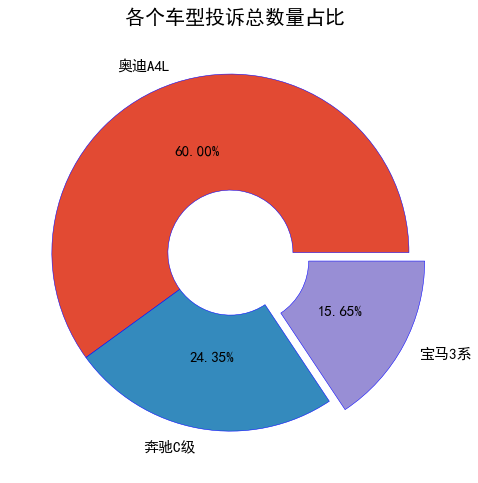

In [28]:
plt.figure(figsize=(8,11)) 
plt.pie(df_percent['百分比'], labels=df_percent['车型'], explode= (0,0,0.1),autopct='%2.2f%%',textprops={'fontsize':15,'color':'black'},wedgeprops=dict(width=0.65,edgecolor='b'))
plt.title(" 各个车型投诉总数量占比",fontsize = 20)

 - 奥迪A4L一个车系独占60%的投诉总量！是车子的质量问题吗？
 - 我们来结合销量看一下

In [29]:
df_sales = pd.read_excel('D:\\数据科学家之路\\BBA\\BBA质量投诉.xls', sheet_name="销量")
df_sales.head()

,时间,奥迪A4,宝马3系,奔驰C
0,2019-12-01,15800,11000,13600
1,2019-11-01,14776,10188,13638
2,2019-10-01,15409,8962,11602
3,2019-09-01,15274,8661,13803
4,2019-08-01,11936,5347,13203


In [30]:
df_sales.describe()

,奥迪A4,宝马3系,奔驰C
count,132.000000,132.000000,132.000000
mean,9140.295455,10559.628788,6135.833333
std,3679.090484,3479.573316,4572.205660
min,924.000000,2543.000000,10.000000
25%,6531.500000,8224.000000,2272.500000
50%,9625.000000,10128.000000,3886.500000
75%,11001.250000,12680.500000,10197.250000
max,20908.000000,21978.000000,18408.000000


In [43]:
# 计算总销量
df_percent['销量(2009-2019)'] = [df_sales['奥迪A4'].sum(),df_sales['奔驰C'].sum(),
                               df_sales['宝马3系'].sum()]
df_percent

,车型,投诉数量,百分比,销量,销量(2009-2019)
0,奥迪A4L,2070,0.600000,1206519,1206519
1,奔驰C级,840,0.243478,809930,809930
2,宝马3系,540,0.156522,1393871,1393871


(array([      0.,  200000.,  400000.,  600000.,  800000., 1000000.,
        1200000., 1400000., 1600000.]), <a list of 9 Text yticklabel objects>)

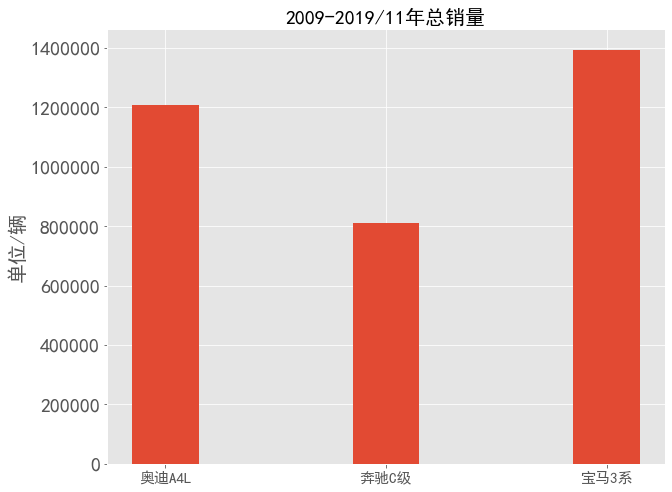

In [48]:
plt.figure(figsize=(10,8))
plt.bar(df_percent['车型'], df_percent['销量(2009-2019)'], width= 0.3)
plt.ylabel('单位/辆',fontsize = 20)
plt.xticks(fontsize = 15)
plt.title('2009-2019/11年总销量', fontsize = 20)
plt.yticks(fontsize = 20)

In [49]:
df_sales.head()

,时间,奥迪A4,宝马3系,奔驰C
0,2019-12-01,15800,11000,13600
1,2019-11-01,14776,10188,13638
2,2019-10-01,15409,8962,11602
3,2019-09-01,15274,8661,13803
4,2019-08-01,11936,5347,13203


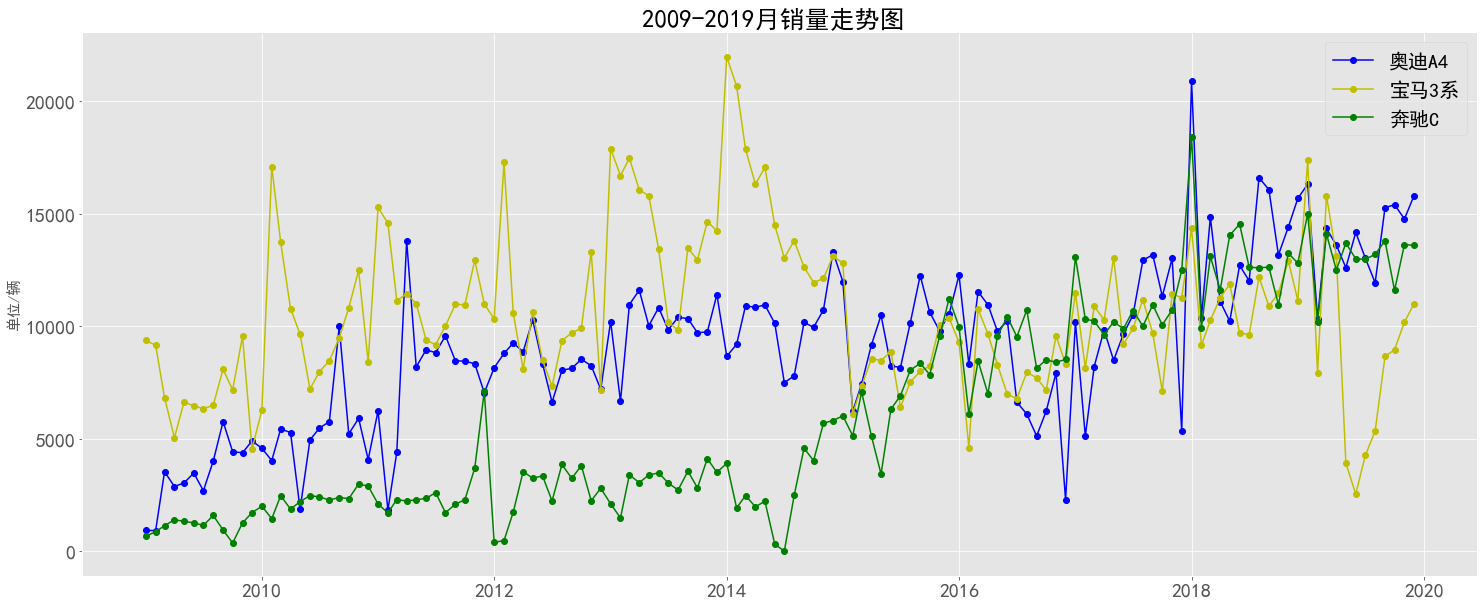

In [63]:
# 销量走势图
plt.figure(figsize=(25,10))

plt.plot(df_sales['时间'],df_sales['奥迪A4'],'bo',linestyle = '-', label = '奥迪A4')
plt.plot(df_sales['时间'],df_sales['宝马3系'],'yo' ,linestyle = '-', label = '宝马3系')
plt.plot(df_sales['时间'],df_sales['奔驰C'],'go',linestyle = '-', label = '奔驰C')
plt.ylabel('单位/辆', fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('2009-2019月销量走势图 ',fontsize = 25)
plt.legend(fontsize = 20)

 - 宝马3系总销量最高，总投诉最少。从数据来看产品质量最靠谱
 - 奥迪销量与宝马差距不大，但是投诉总量是宝马近4倍。
 - 奔驰总销量最低，但是投诉量并不少
 - 另外2009-2015，宝马的历年销量最高，奔驰非常低，月销量大部分再2000-3000之间。但是2015年之后产品开始发力
 - 最近几年：2015-2019，三个车型的销量非常接近，竞争越来越激烈


In [64]:
df.head()

,投诉编号,品牌,车型,车款,投诉问题,投诉日期
0,449177,一汽-大众奥迪,奥迪A4L,2017款 2.0T 双离合 进取型,节温器漏防冻液严重,2020-02-28
1,448806,一汽-大众奥迪,奥迪A4L,2019款 40 TFSI 时尚型 国V,经销商服务态度差,2020-02-26
2,448786,一汽-大众奥迪,奥迪A4L,2017款 2.0T 双离合 风尚型,发动机水泵故障节温器漏水,2020-02-26
3,448632,一汽-大众奥迪,奥迪A4L,2019款 40 TFSI 进取型 国VI,行驶中提示变速箱故障,2020-02-25
4,448241,一汽-大众奥迪,奥迪A4L,2016款 2.0T CVT 舒适型 典藏版,节温器故障要求召回处理,2020-02-22


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3450 entries, 0 to 3449
Data columns (total 6 columns):
投诉编号    3450 non-null int64
品牌      3450 non-null object
车型      3450 non-null object
车款      3450 non-null object
投诉问题    3450 non-null object
投诉日期    3450 non-null object
dtypes: int64(1), object(5)
memory usage: 161.8+ KB


In [67]:
df['投诉日期'] = pd.to_datetime(df['投诉日期'])
df['month'] = df['投诉日期'].values.astype('datetime64[M]')
df.head()

,投诉编号,品牌,车型,车款,投诉问题,投诉日期,month
0,449177,一汽-大众奥迪,奥迪A4L,2017款 2.0T 双离合 进取型,节温器漏防冻液严重,2020-02-28,2020-02-01
1,448806,一汽-大众奥迪,奥迪A4L,2019款 40 TFSI 时尚型 国V,经销商服务态度差,2020-02-26,2020-02-01
2,448786,一汽-大众奥迪,奥迪A4L,2017款 2.0T 双离合 风尚型,发动机水泵故障节温器漏水,2020-02-26,2020-02-01
3,448632,一汽-大众奥迪,奥迪A4L,2019款 40 TFSI 进取型 国VI,行驶中提示变速箱故障,2020-02-25,2020-02-01
4,448241,一汽-大众奥迪,奥迪A4L,2016款 2.0T CVT 舒适型 典藏版,节温器故障要求召回处理,2020-02-22,2020-02-01


In [68]:
df.tail()

,投诉编号,品牌,车型,车款,投诉问题,投诉日期,month
3445,21297,华晨宝马,宝马3系,2010款 318i 2.0 自动 领先型,发动机烧机油现象严重,2012-12-23,2012-12-01
3446,20841,华晨宝马,宝马3系,2011款 320i 2.0 自动 豪华型,普利司通轮胎大面积开裂,2012-12-12,2012-12-01
3447,20413,华晨宝马,宝马3系,2013款 320Li 2.0T 自动 时尚型,正常行使中发动机突然熄火,2012-12-01,2012-12-01
3448,19008,华晨宝马,宝马3系,2013款 320Li 2.0T 自动 时尚型,车辆行驶过程中突然熄火,2012-10-19,2012-10-01
3449,18424,华晨宝马,宝马3系,2010款 320i 2.0 自动 时尚型,马牌轮胎起皮问题,2012-09-26,2012-09-01


## 1.按照月份进行数据统计分析
  - 每个车型的每个月投诉数量

In [73]:
group_month = df.pivot_table(index = 'month', columns = '车型', values = '品牌',aggfunc='count')
group_month

车型,奔驰C级,奥迪A4L,宝马3系
month,,,
2011-10-01,NaN,2.0,NaN
2012-02-01,NaN,1.0,NaN
2012-03-01,NaN,1.0,NaN
2012-05-01,NaN,4.0,NaN
2012-06-01,NaN,2.0,NaN
...,...,...,...
2019-10-01,30.0,38.0,17.0
2019-11-01,19.0,38.0,15.0
2019-12-01,23.0,49.0,23.0


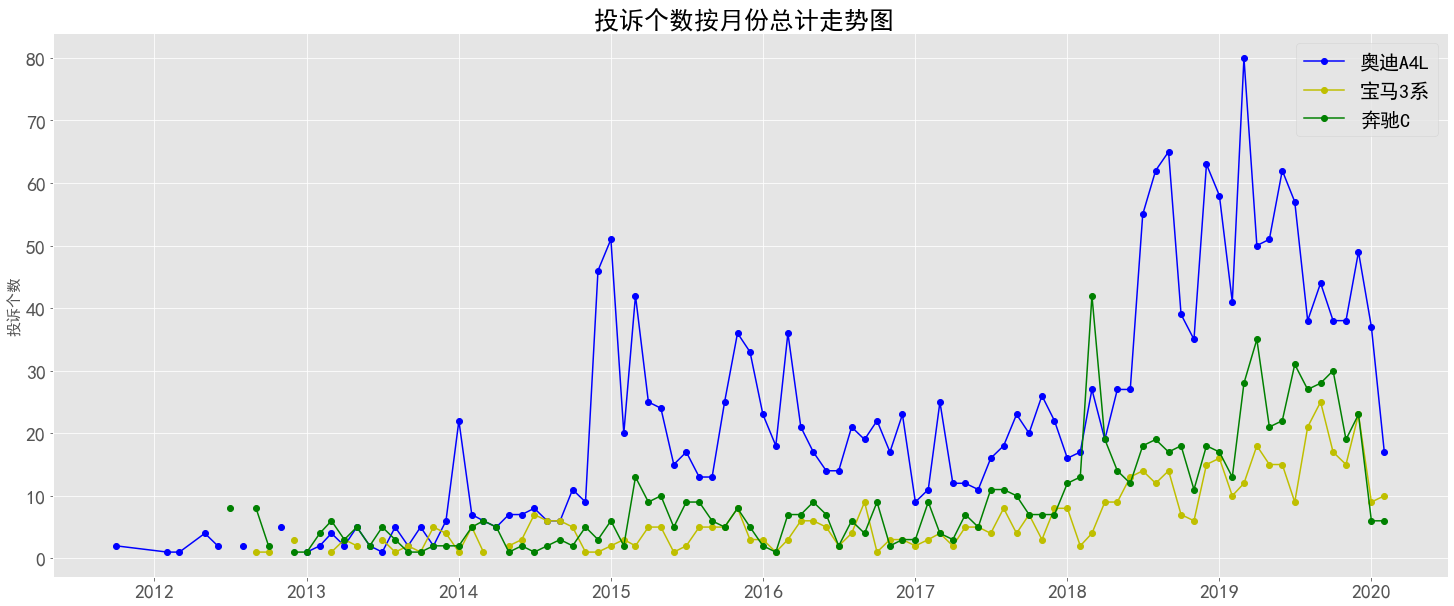

In [77]:
plt.figure(figsize=(25,10))

plt.plot(group_month.index,group_month['奥迪A4L'],'bo',linestyle = '-', label = '奥迪A4L')
plt.plot(group_month.index,group_month['宝马3系'],'yo' ,linestyle = '-', label = '宝马3系')
plt.plot(group_month.index,group_month['奔驰C级'],'go',linestyle = '-', label = '奔驰C')
plt.ylabel('投诉个数', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('投诉个数按月份总计走势图 ',fontsize = 25)
plt.legend(fontsize = 20)

 - 基本上每个月奥迪的投诉总量都是最高，宝马最低。
 - 宝马和奔驰的投诉数量近几年有增长的趋势
 - 奥迪在2015年前后和2017-2019年有个投诉集中爆发的阶段